In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import rasterio
import json
from pprint import pprint
from scipy.misc import bytescale

%matplotlib inline
# from earthpy import spatial as es

In [2]:
def plot_rgb(arr, vmin=0, vmax=255, extent=None):
    
    if arr.shape[-1] != 3:
        raise Exception('Input needs to be 3 band, and band channel needs to be last channel')
        
    if type(arr) is np.ma.MaskedArray:
        # build alpha channel        
        mask = np.ma.getmask(arr[:,:,0])
        mask = ~mask * 255
        
        # add the mask to the array (ise earthpy bytescale)
        plot_arr = np.dstack((bytescale(arr),mask))
        
        # plot it
        plt.imshow(plot_arr, vmin=vmin, vmax=vmax, extent=extent)
        plt.show()
        
    else: #no mask, no worries
        plt.imshow(bytescale(arr))
        
    return None

In [3]:
## we will pick a scene over the front range. Check out the files in the folder on AWS
#aws_scene_path = 'landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180611_20180615_01_T1'
aws_scene_path = 'landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1'
!aws s3 ls $aws_scene_path/ --no-sign-request

2018-06-05 23:05:07     117266 LC08_L1TP_034032_20180526_20180605_01_T1_ANG.txt
2018-06-05 23:04:50   64543762 LC08_L1TP_034032_20180526_20180605_01_T1_B1.TIF
2018-06-05 23:04:52    8291279 LC08_L1TP_034032_20180526_20180605_01_T1_B1.TIF.ovr
2018-06-05 23:04:37   58906434 LC08_L1TP_034032_20180526_20180605_01_T1_B10.TIF
2018-06-05 23:04:52    8326690 LC08_L1TP_034032_20180526_20180605_01_T1_B10.TIF.ovr
2018-06-05 23:04:36      11605 LC08_L1TP_034032_20180526_20180605_01_T1_B10_wrk.IMD
2018-06-05 23:04:54   57516650 LC08_L1TP_034032_20180526_20180605_01_T1_B11.TIF
2018-06-05 23:04:41    8174375 LC08_L1TP_034032_20180526_20180605_01_T1_B11.TIF.ovr
2018-06-05 23:04:42      11605 LC08_L1TP_034032_20180526_20180605_01_T1_B11_wrk.IMD
2018-06-05 23:04:36      11605 LC08_L1TP_034032_20180526_20180605_01_T1_B1_wrk.IMD
2018-06-05 23:05:06   65529406 LC08_L1TP_034032_20180526_20180605_01_T1_B2.TIF
2018-06-05 23:04:56    8405569 LC08_L1TP_034032_20180526_20180605_01_T1_B2.TIF.ovr
2018-06-05 23:04:

# since we don't have AWSCLI configured, we will need to download the data before we can load it.

In [4]:
scene_base = os.path.basename(aws_scene_path) # all after last slash
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'] # need these for the file paths

# specify an output directory to hold the files. create it if it doesn't exist
L8_dir = 'data_L8'
if not os.path.exists(L8_dir):
    os.mkdir(L8_dir)

# iterate through the bands list to download the data
for band in bands:
    sample_band = aws_scene_path + '/{}_{}.TIF'.format(scene_base, band)
    s3_path = "s3://{}".format(sample_band)
    print(s3_path)
    
    # copy from S3 if not done already
    if not os.path.exists(L8_dir + '/{}_{}.TIF'.format(scene_base, band)):
        !aws s3 cp $s3_path $L8_dir
    

s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_B1.TIF
s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_B2.TIF
s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_B3.TIF
s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_B4.TIF
s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_B5.TIF
s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_B6.TIF
s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_B7.TIF


# also get the json file, to view the metadata

In [5]:
# download the JSON file if it doesn't exist already
json_path = 's3://' + aws_scene_path + '/{}_MTL.json'.format(scene_base)

if not os.path.exists(L8_dir + '/{}_MTL.json'.format(scene_base)):
    !aws s3 cp $json_path $L8_dir

In [6]:
# load the file
local_mtl = L8_dir + '/{}_MTL.json'.format(scene_base)

with open(local_mtl, 'r') as f:
    mtl = json.load(f)
    
# show it with pretty print    
pprint(mtl)

{'L1_METADATA_FILE': {'IMAGE_ATTRIBUTES': {'CLOUD_COVER': 3.36,
                                           'CLOUD_COVER_LAND': 3.36,
                                           'EARTH_SUN_DISTANCE': 1.0130559,
                                           'GEOMETRIC_RMSE_MODEL': 7.082,
                                           'GEOMETRIC_RMSE_MODEL_X': 4.869,
                                           'GEOMETRIC_RMSE_MODEL_Y': 5.143,
                                           'GEOMETRIC_RMSE_VERIFY': 3.313,
                                           'GROUND_CONTROL_POINTS_MODEL': 427,
                                           'GROUND_CONTROL_POINTS_VERIFY': 111,
                                           'GROUND_CONTROL_POINTS_VERSION': 4,
                                           'IMAGE_QUALITY_OLI': 9,
                                           'IMAGE_QUALITY_TIRS': 9,
                                           'ROLL_ANGLE': -0.001,
                                           'SATURATI

# now that the GeoTIFFs are downloaded, load them into a raster stack

In [7]:
band_arrs = [] # empty list to store the data arrays
for band in bands:
    sample_band = L8_dir + '/{}_{}.TIF'.format(scene_base, band)
    with rasterio.open(sample_band, 'r') as src:
        arr = src.read(1) # to read in as shape [rows, cols], not [band, rows, cols]
        
    band_arrs.append(arr)
    
# then convert to numpy array, and delete the list
arr_L8 = np.array(band_arrs)
del band_arrs

# mask the nodata
# arr_L8 = np.ma.masked_equal(rgb_arr, 0)

arr_L8.shape

(7, 7911, 7781)

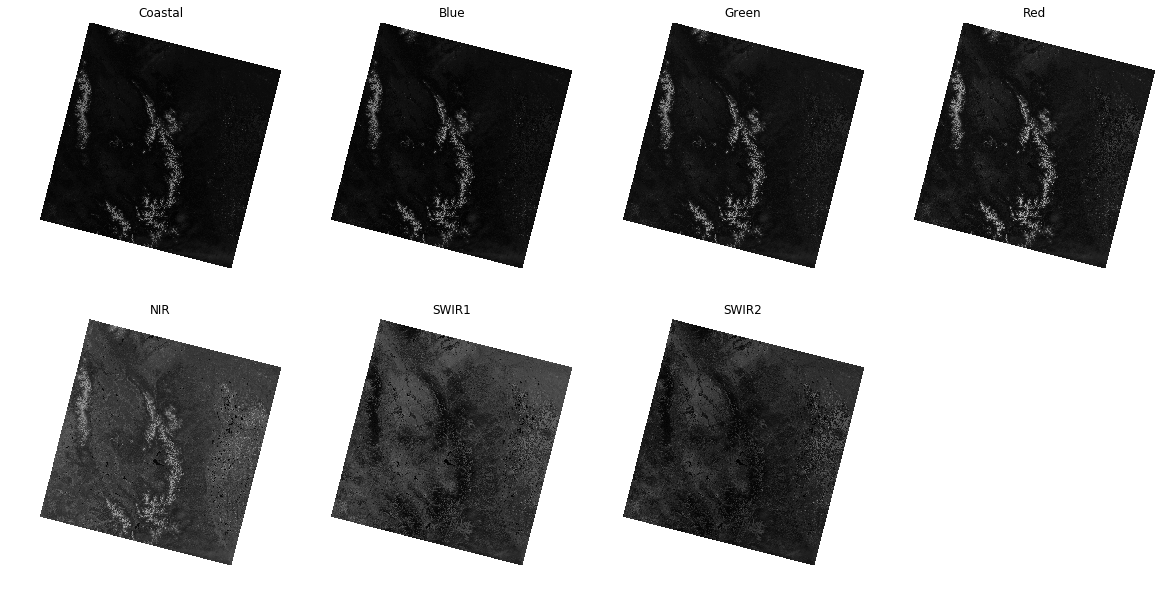

In [8]:
# plot the bands
plt.figure(figsize=(20,10))


channels = ['Coastal', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'] # used for plot titles
for i in range(arr_L8.shape[0]):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plot_band = np.ma.masked_equal(arr_L8[i], 0)
    plt.imshow(plot_band, cmap="Greys_r")
    plt.title(channels[i])
plt.show()




C:\anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


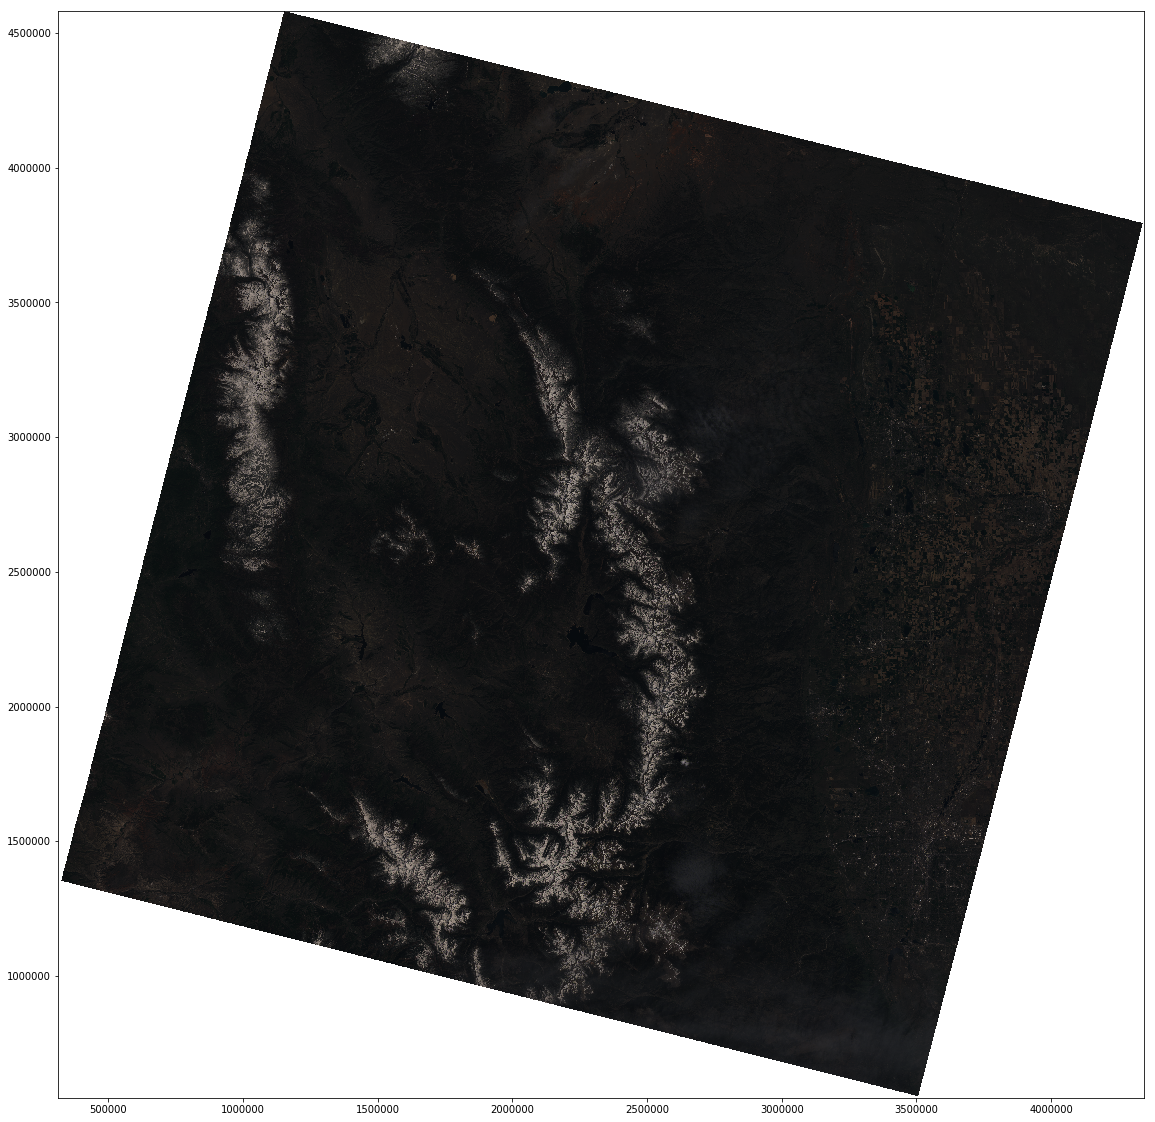

In [9]:
# and display as RGB
# define extent for plotting (optional)
xmin = mtl['L1_METADATA_FILE']['PRODUCT_METADATA']['CORNER_LL_PROJECTION_X_PRODUCT']
ymin = mtl['L1_METADATA_FILE']['PRODUCT_METADATA']['CORNER_LL_PROJECTION_Y_PRODUCT']
xmax = mtl['L1_METADATA_FILE']['PRODUCT_METADATA']['CORNER_UR_PROJECTION_X_PRODUCT']
ymax = mtl['L1_METADATA_FILE']['PRODUCT_METADATA']['CORNER_UR_PROJECTION_Y_PRODUCT']
extent = [xmin, ymin, xmax, ymax]

# slice the full array for RGB channels
rgb_arr = arr_L8[[3,2,1], :, :]
rgb_arr = np.rollaxis(rgb_arr, 0, 3) # need channel axis to be last for plotting
rgb_arr_ma = np.ma.masked_equal(rgb_arr, 0)

fig, ax = plt.subplots(figsize=(20,20))
plot_rgb(rgb_arr_ma, 50, 150, extent)

## ******some text for NDVI and EVI up here*****


ndvi min/max: -0.38891637803067786 / 0.6967495488739425
c_red min/max: 0.10874788644656047 / 0.3574198954011649


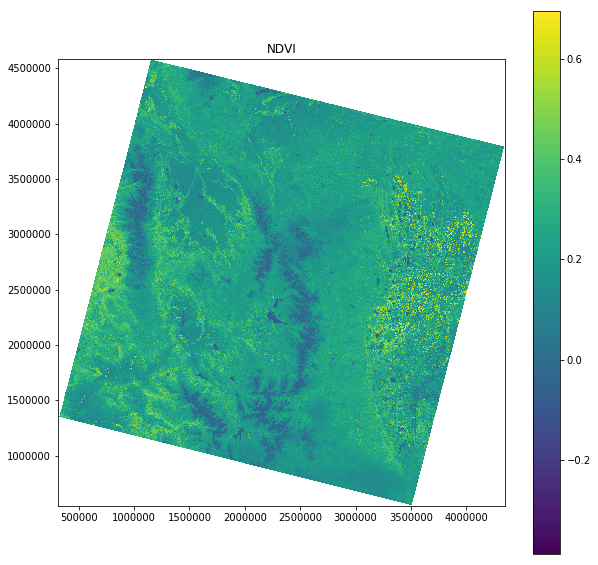

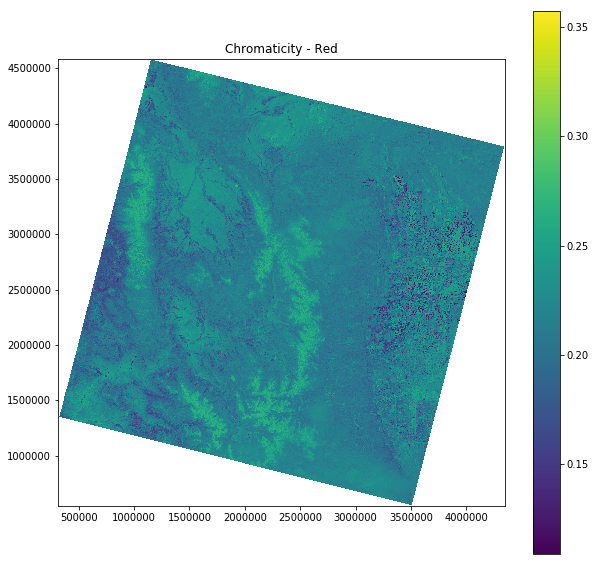

In [10]:
# subset the bands as necessary
blue = arr_L8[1,:,:].astype(np.float)
green = arr_L8[2,:,:].astype(np.float)
red = arr_L8[3,:,:].astype(np.float)
nir = arr_L8[4,:,:].astype(np.float)

# mask them
blue = np.ma.masked_equal(blue,0)
red = np.ma.masked_equal(red,0)
nir = np.ma.masked_equal(nir,0)

# define NDVI..  maybe look at some stats?
ndvi = (nir - red) / (nir + red)
print('ndvi min/max: {} / {}'.format(ndvi.min(), ndvi.max()))

# define a chromaticity coordinate..  maybe look at some stats?
c_red = red / (blue + green + red + nir)
print('c_red min/max: {} / {}'.format(c_red.min(), c_red.max()))

fig, ax = plt.subplots(figsize=(10,10))
cf = ax.imshow(ndvi, extent=extent) # change cmap
ax.set_title('NDVI')
fig.colorbar(cf, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
cf = ax.imshow(c_red, extent=extent) # change cmap
ax.set_title('Chromaticity - Red')
fig.colorbar(cf, ax=ax)

plt.show()


## use scikit learn for clustering on all 7 bands and then b/g/r/nir chromaticity bands. compare


C:\anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


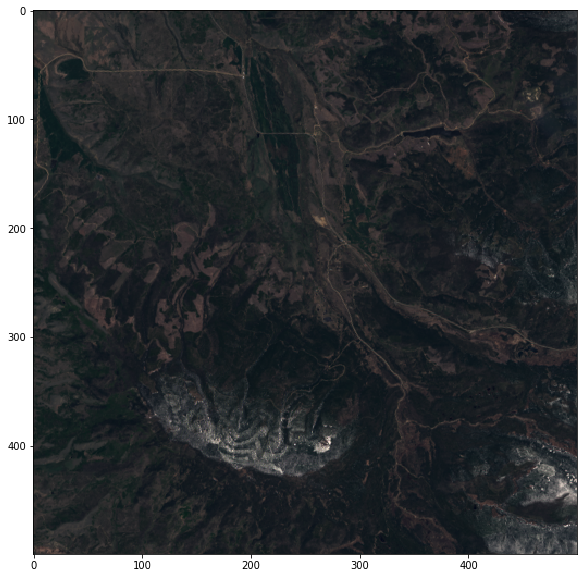

In [11]:
# first let's define a subset of the image 
pix_win = 500
r_start = 3000
r_end = r_start + pix_win
c_start = 3000
c_end = c_start + pix_win

# slice the input image
test_im = arr_L8[:,r_start:r_end, c_start:c_end]

# plot it in RGB
plt.figure(figsize=(10,10))
plt.imshow(bytescale(rgb_arr[r_start:r_end, c_start:c_end,:]))
plt.show()

C:\anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel\__main__.py:23: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


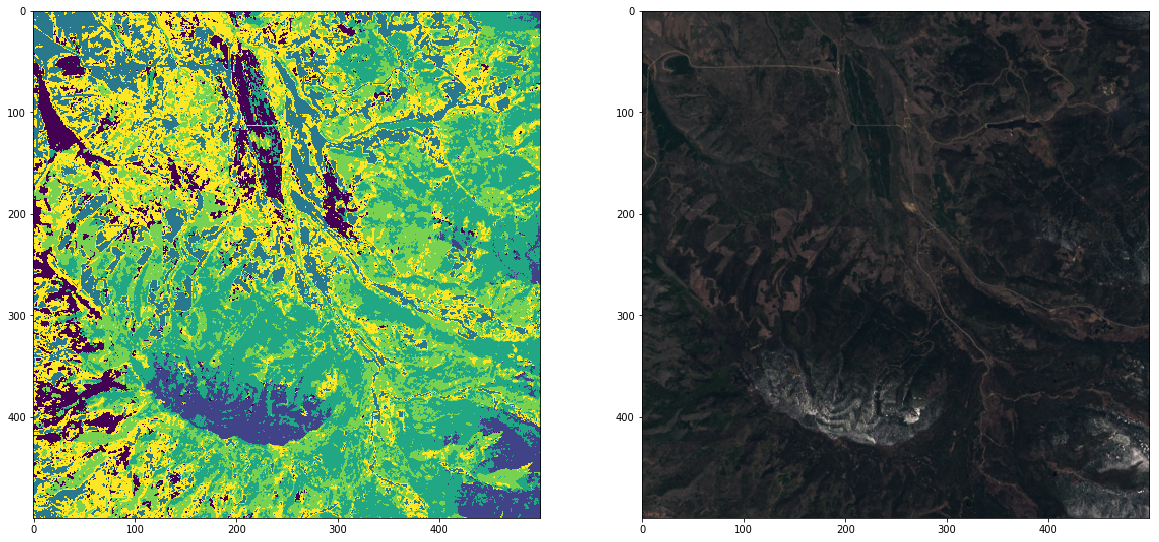

In [12]:
from sklearn.cluster import KMeans

# define number of clusters and create classifier
n_clusters = 6
clf = KMeans(n_clusters=n_clusters, random_state=0) # set a random state for similar results

## fit the K-means classifier on the 7 Landsat bands
# first reshape the array so channels are last axis. 
im_reshape = np.rollaxis(test_im, 0, 3).astype('float32')

# reshape again into columns for each channel
X = im_reshape.reshape(-1, im_reshape.shape[-1])

# fit the classifier
labels_test_im = clf.fit_predict(X, y=None)

# reshape the labels to the image size
labels_test_im_arr = np.reshape(labels_test_im, (test_im.shape[1], test_im.shape[2]))

## show the result
fig, ax = plt.subplots(1,2, figsize = (20, 20))
ax[0].imshow(labels_test_im_arr)
ax[1].imshow(bytescale(rgb_arr[r_start:r_end, c_start:c_end,:]))
plt.show()

C:\anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel\__main__.py:30: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


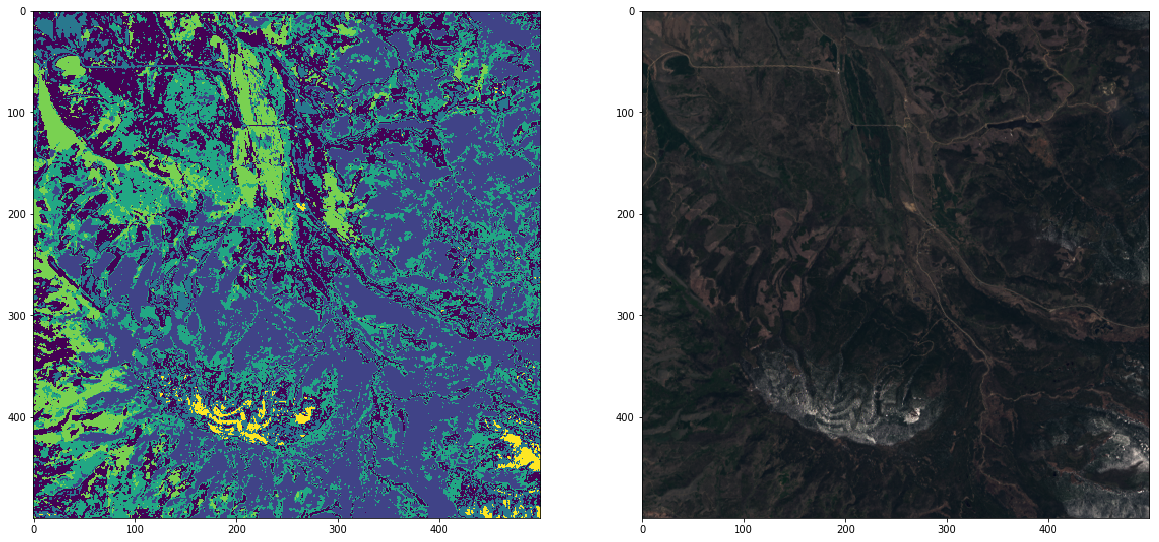

In [13]:
## look at it for chromaticity

# define number of clusters and create classifier
n_clusters = 6
clf = KMeans(n_clusters=n_clusters, random_state=0) # set a random state for similar results

## fit the K-means classifier on the 7 Landsat bands
# first reshape the array so channels are last axis. 
im_reshape = np.rollaxis(test_im, 0, 3).astype('float32')

# reshape again into columns for each channel
X = im_reshape.reshape(-1, im_reshape.shape[-1])

# use only the Blue/Green/Red/NIR channels
Xc = X[:, [1,2,3,4]]

# normalize by the sum to get chromaticity
Xc = Xc / Xc.sum(axis=0)


# fit the classifier
labels_test_chrom = clf.fit_predict(Xc, y=None)

# reshape the labels to the image size
labels_test_chrom_arr = np.reshape(labels_test_chrom, (test_im.shape[1], test_im.shape[2]))

## show the result
fig, ax = plt.subplots(1,2, figsize = (20, 20))
ax[0].imshow(labels_test_chrom_arr)
ax[1].imshow(bytescale(rgb_arr[r_start:r_end, c_start:c_end,:]))
plt.show()